To make it easier for everyone to access the large (50+ GB) data in bite-sized chunks, I have written a script called repackage_data.py (under dustcurve/) which inputs a healpy nside 128 index and outputs a repackaged data file called index.h5, containing all the stellar posterior, stellar coordinate, and CO intensity data for that index. A healpy nside 128 pixel index essentially identifies a unique 0.2 sq. deg. chunk of area on the sky, so when you input the index, you're outputting all the relevant information needed to run the MCMC code on that specific bite-sized area of the sky. All the mini-area files will eventually be made available on a public Odyssey server, so users will be able to retrieve only as much data as they need. 

For the purposes of this tutorial, I used repackage_data.py to create a data file called "8998.h5" which contains over a thousand stars for a 0.2 sq. deg. chunk of area, centered right in the middle of our cloud of interest (the Cepheus molecular cloud). While we would like to eventually run the script on the entire area covering Cepheus (approximately 3x3 deg), we are going to pick a small section to make sure the script is running smoothly with real data. 

This tutorial will closely mimic the analysis done in model.ipynb, except now we're using real data and we're trying to estimate the values of d1-12, not just d7 and d11 (as in our thought experiment). Despite the fact that we're only using a small subset of the data, our values for d1-12 should still hover around the distance to the Cepheus molecular cloud given by the literature (approximately d=8-10). So once again we are going to set our walker off at completely random distances, and see if it can find it's way back to the literature-accepted value. 

For reference, this is what the stacked stellar posterior array (created by summing all the individual stellar posterior arrays along the depth axis) looks like for our region of interest. This stellar posterior consists of over a 1000 stars. 
<img src="posterior_sum_89998.png">


In [1]:
import emcee
from dustcurve import model_test
import seaborn as sns
import numpy as np
from dustcurve import pixclass
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from dustcurve import io
%matplotlib inline

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io.fetch_args('89998.h5',[6,15],0.03)

#This MH Code has been adapted from code snippets found in the PHYS 201 week 9 MCMC notebook...

# the model has 24 parameters; we'll use 50 walkers, 500 steps each, at 5 different temps
ndim=12
nwalkers = 50
nsteps = 500
ntemps=5

result=[9.3 for i in range(ndim)]

starting_positions = [[result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model_test.log_likelihood, model_test.log_prior, loglargs=(ldata), logpargs=[pdata])

# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')



CPU times: user 4h 44min 36s, sys: 29.5 s, total: 4h 45min 6s
Wall time: 4h 44min 59s
Done


Our mean acceptance fraction for the coldest chain is 0.09
d1= 9.27 + 2.03 - 1.90
d2= 9.30 + 1.38 - 1.35
d3= 9.33 + 2.41 - 1.55
d4= 9.00 + 2.49 - 1.30
d5= 9.08 + 0.87 - 1.22
d6= 9.03 + 0.85 - 0.91
d7= 8.87 + 0.99 - 0.98
d8= 9.11 + 1.36 - 1.56
d9= 9.26 + 2.92 - 1.44
d10= 9.20 + 2.50 - 1.65
d11= 9.17 + 1.80 - 1.55
d12= 9.16 + 1.67 - 1.15


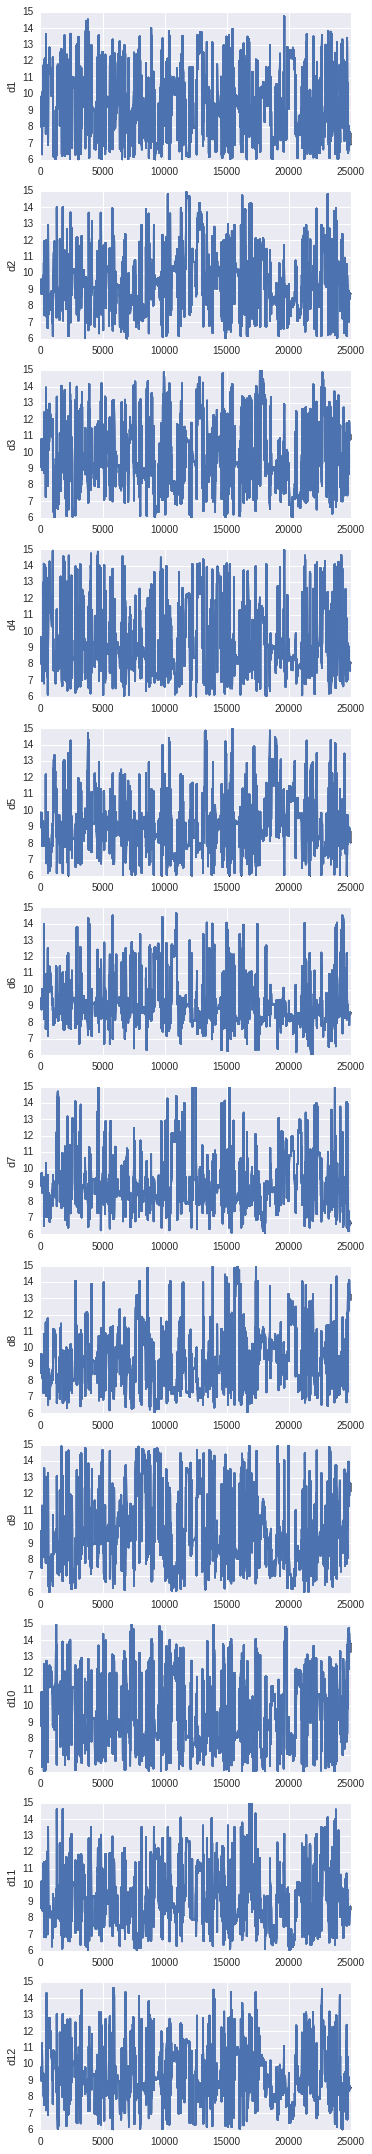

In [5]:
#check out acceptance fraction:
print("Our mean acceptance fraction for the coldest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

samples_cold = sampler.chain[0,:,:,:]
traces_cold = samples_hot.reshape(-1, ndim).T
    
#set up subplots for chain plotting
fig, (ax_d1, ax_d2, ax_d3, ax_d4, ax_d5, ax_d6, ax_d7, ax_d8, ax_d9, ax_d10, ax_d11, ax_d12) = plt.subplots(12, figsize=(5,30))

plt.tight_layout()

#label axes
ax_d1.set(ylabel='d1')
ax_d2.set(ylabel='d2')
ax_d3.set(ylabel='d3')
ax_d4.set(ylabel='d4')
ax_d5.set(ylabel='d5')
ax_d6.set(ylabel='d6')
ax_d7.set(ylabel='d7')
ax_d8.set(ylabel='d8')
ax_d9.set(ylabel='d9')
ax_d10.set(ylabel='d10')
ax_d11.set(ylabel='d11')
ax_d12.set(ylabel='d12')

for i in range(10):
    sns.tsplot(traces_cold[0], ax=ax_d1)
    sns.tsplot(traces_cold[1], ax=ax_d2)
    sns.tsplot(traces_cold[2], ax=ax_d3)
    sns.tsplot(traces_cold[3], ax=ax_d4)
    sns.tsplot(traces_cold[4], ax=ax_d5)
    sns.tsplot(traces_cold[5], ax=ax_d6)
    sns.tsplot(traces_cold[6], ax=ax_d7)
    sns.tsplot(traces_cold[7], ax=ax_d8)
    sns.tsplot(traces_cold[8], ax=ax_d9)
    sns.tsplot(traces_cold[9], ax=ax_d10)
    sns.tsplot(traces_cold[10], ax=ax_d11)
    sns.tsplot(traces_cold[11], ax=ax_d12)

parameter_samples = pd.DataFrame({'d1': traces_cold[0], 'd2': traces_cold[1], 'd3': traces_cold[2], 
                                  'd4': traces_cold[3], 'd5': traces_cold[4], 'd6': traces_cold[5],
                                  'd7': traces_cold[6], 'd8': traces_cold[7], 'd9': traces_cold[8],
                                  'd10': traces_cold[9], 'd11': traces_cold[10], 'd12': traces_cold[11]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

#what values do we get?
for i in range(1,13):
    print("d"+str(i)+"= {:.2f} + {:.2f} - {:.2f}".format(q["d"+str(i)][0.50], 
                                                q["d"+str(i)][0.84]-q["d"+str(i)][0.50],
                                                q["d"+str(i)][0.50]-q["d"+str(i)][0.16]))